In [1]:
import os
import pandas as pd

current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')

final_df = pd.read_csv(final_path)

### Przygotowanie danych

In [2]:
from util import prepare_final

final_df = prepare_final(final_df)

final_df.head()

,premium_user,popularity_mean,popularity_std,popularity_min,popularity_max,duration_ms_mean,duration_ms_std,duration_ms_min,duration_ms_max,explicit_ratio,...,q,r,s,t,u,v,w,x,y,z
0,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.059379,-0.409611,-0.430490,-0.491912,-1.065425,...,0,1,0,1,1,0,1,0,0,0
1,False,1.066575,0.740434,2.270742,0.713372,0.661699,-0.043242,1.994549,-0.098518,0.176852,...,0,1,0,1,0,1,1,0,0,0
2,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.429353,-0.963033,0.339053,-0.735753,-0.814081,...,0,1,1,0,1,0,0,0,0,0
3,False,-0.997069,-0.995204,-0.319064,-0.994713,-1.192440,-0.607767,-1.304843,-0.491912,-0.613005,...,0,1,0,1,1,1,1,0,1,0
4,False,1.056186,1.104850,0.544205,0.968310,0.678373,-0.770022,0.842162,-0.812626,2.439812,...,0,1,1,1,1,0,0,0,0,0


In [3]:
from sklearn.model_selection import train_test_split

X = final_df.drop('premium_user', axis=1)
y = final_df['premium_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Klasyfikator Random Forest
Uczenie

In [4]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.79
ROC AUC: 0.85
Precision: 0.81
Recall: 0.66
F1 Score: 0.72


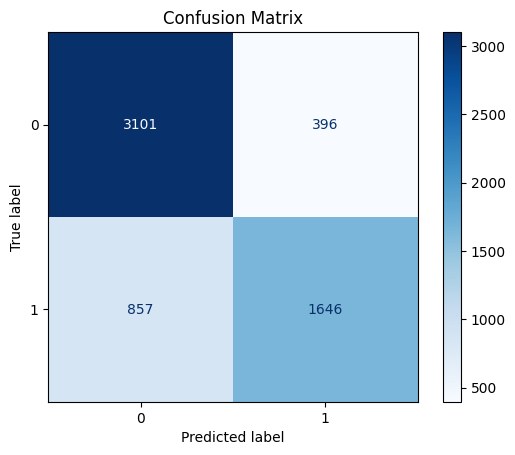

In [5]:
import sklearn.metrics as metrics

accuracy = metrics.accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = metrics.roc_auc_score(y_test, y_pred_proba)
print(f'ROC AUC: {roc_auc:.2f}')

precision = metrics.precision_score(y_test, y_pred)
print(f'Precision: {precision:.2f}')

recall = metrics.recall_score(y_test, y_pred)
print(f'Recall: {recall:.2f}')

f1 = metrics.f1_score(y_test, y_pred)
print(f'F1 Score: {f1:.2f}')

cm = metrics.confusion_matrix(y_test, y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

Selekcja atrybutów

In [9]:
importances = clf.feature_importances_

indices = np.argsort(importances)[::-1]

n = 22
selected_features = X_train.columns[indices][:n]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

X_train_selected.head()

,skip_play_ratio,like_play_ratio,city_frequency,danceability_mean,unique_track_count,unique_artist_count,explicit_count,valence_mean,acousticness_mean,energy_mean,...,instrumentalness_mean,loudness_mean,tempo_mean,duration_ms_mean,loudness_std,speechiness_std,liveness_std,liveness_mean,popularity_max,tempo_std
21753,1.148967,0.893592,-0.389192,-1.021799,-0.796238,-0.636550,0.091560,-1.284575,-1.029090,1.070645,...,-0.541855,0.952728,1.340730,1.263806,-0.289353,-0.353985,1.352700,1.599924,1.121273,-0.064918
251,1.276084,0.732191,0.102809,-0.930207,-0.272982,-0.423377,0.201087,-0.771339,-1.016714,0.898991,...,-0.916972,0.932203,1.431286,1.302052,-1.103128,-1.070056,0.547463,0.123498,1.121273,0.938075
22941,1.310879,0.870949,0.544605,-1.440138,0.168194,0.024288,0.201087,-0.950466,-1.032443,1.186216,...,-1.161595,1.269039,1.433755,1.366085,-1.052244,-0.910295,2.342913,2.833155,1.044791,0.486191
618,1.241430,0.982545,1.182197,-1.188012,0.794049,0.962253,1.077297,-0.809741,-1.021179,0.958725,...,-1.099546,0.870467,0.936312,0.837148,-0.555151,-0.948681,0.383203,-0.335711,1.121273,0.279101
17090,-0.886245,-1.072747,-1.322988,1.205763,-1.360533,-1.382658,-0.784650,1.716267,1.062402,-0.933159,...,0.942475,-1.017222,-0.363751,-1.530408,1.103620,0.555705,-1.686416,-1.307060,-0.994713,0.529029


In [10]:
clf_selected = RandomForestClassifier(n_estimators=100)
clf_selected.fit(X_train_selected, y_train)

y_pred_selected = clf_selected.predict(X_test_selected)
y_pred_proba_selected = clf_selected.predict_proba(X_test_selected)[:, 1]

Accuracy: 0.79
ROC AUC: 0.85
Precision: 0.80
Recall: 0.66
F1 Score: 0.72


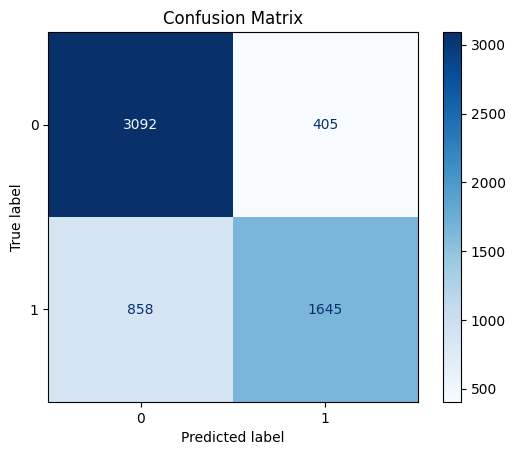

In [13]:
accuracy = metrics.accuracy_score(y_test, y_pred_selected)
print(f'Accuracy: {accuracy:.2f}')

roc_auc = metrics.roc_auc_score(y_test, y_pred_proba_selected)
print(f'ROC AUC: {roc_auc:.2f}')

precision = metrics.precision_score(y_test, y_pred_selected)
print(f'Precision: {precision:.2f}')

recall = metrics.recall_score(y_test, y_pred_selected)
print(f'Recall: {recall:.2f}')

f1 = metrics.f1_score(y_test, y_pred_selected)
print(f'F1 Score: {f1:.2f}')

cm = metrics.confusion_matrix(y_test, y_pred_selected)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [14]:
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')
X_selected = X[selected_features]
X_selected.to_csv(selected_path, index=False)

Index(['skip_play_ratio', 'like_play_ratio', 'city_frequency',
       'danceability_mean', 'unique_track_count', 'unique_artist_count',
       'explicit_count', 'valence_mean', 'acousticness_mean', 'energy_mean',
       'instrumentalness_std', 'speechiness_mean', 'instrumentalness_mean',
       'loudness_mean', 'tempo_mean', 'duration_ms_mean', 'loudness_std',
       'speechiness_std', 'liveness_std', 'liveness_mean', 'popularity_max',
       'tempo_std'],
      dtype='object')


<Axes: >

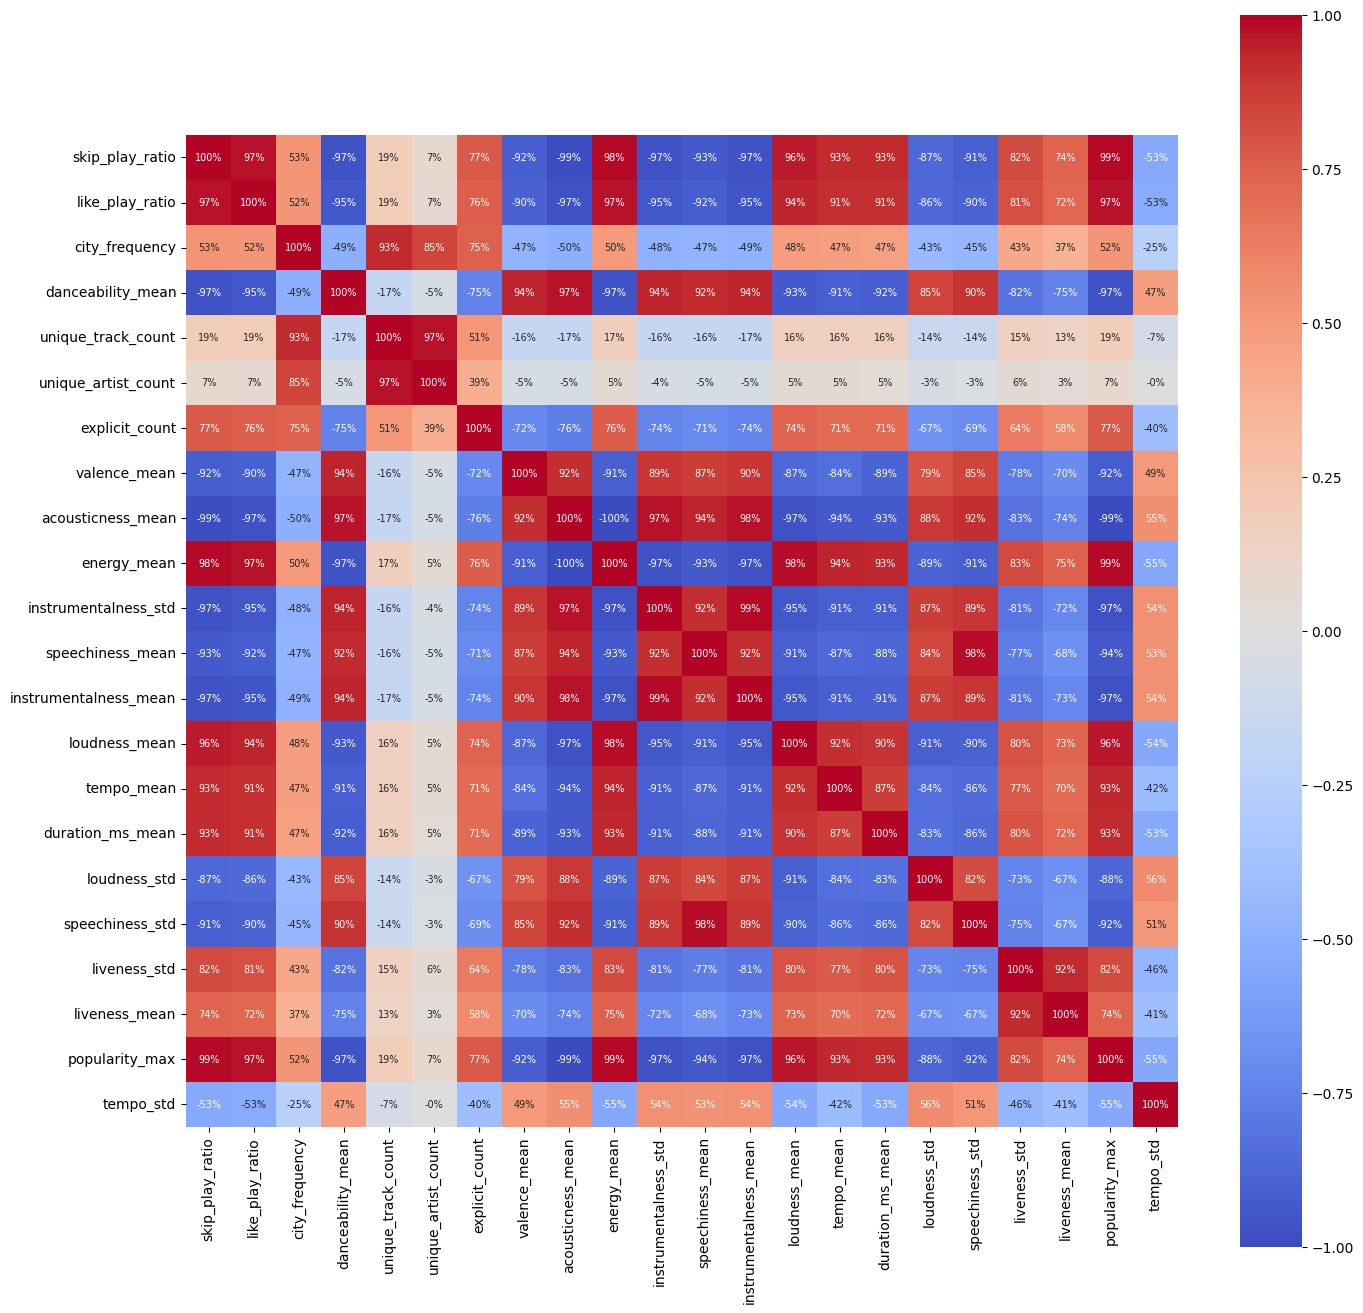

In [15]:
import seaborn as sns

continuous_fields = X_selected.select_dtypes(include=['float64', 'int64'])

print(continuous_fields.columns)

corr_matrix = continuous_fields.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, annot=True, annot_kws={'fontsize': 7}, fmt='.0%', vmin=-1, vmax=1)

Save models

In [34]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'rf_model.joblib')
model_selected_path = os.path.join(current_dir, 'trained', 'rf_selected_model.joblib')

joblib.dump(clf, model_path)
joblib.dump(clf_selected, model_selected_path)

['c:\\_prog\\vm_shared\\Account-Classifier\\models\\trained\\rf_selected_model.joblib']